In [7]:
import numpy as np
from itertools import zip_longest as izip_longest
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
from math import log

def read_data(file_path):
    data = []
    with open(file_path) as fileobj:
        line_count = 0
        number = []
        for line in fileobj:
            line = line.replace('#', '1').replace('+', '1').replace(' ', '0')
            number.append(np.fromiter(line, dtype=int, count=28))
            line_count += 1
            if(line_count == 28):
                line_count = 0
                data.append(np.array(number))
                number = []
    
    return np.array(data)

def compute_prior(labels):
    label_counts = {}
    labels_num = 0
    prior_distribution = {}

    for label in labels:
        labels_num += 1
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1
    
    for i in range(10):
        prior_distribution[i] = float(label_counts[i]) / labels_num
    
    return prior_distribution

def laplace_smoothing(num, alpha, k):
    return float(alpha + num[0]) / ((k * alpha) + num[1])

def estimate_pixel_probabilities(X, y):
    pixel_counts = {}
    pixel_probabilities = {}
    label_counts = {}
    
    for i in range(len(X)):
        label = y[i]
        image = X[i].flatten()

        if label not in label_counts:
            label_counts[label] = 1
        else:
            label_counts[label] += 1
            
        if label not in pixel_counts:
            pixel_counts[label] = [0] * 784
        
        for i in range(len(image)):
            if image[i] == 1:
                pixel_counts[label][i] += 1
    
    for j in range(10):
        n_j = label_counts[j]
        pixel_probabilities[j] = [0] * 784
        for i in range(784):
            n_ji = pixel_counts[j][i]
            p_ji = laplace_smoothing([n_ji, n_j], 0.1, 2)
            pixel_probabilities[j][i] = p_ji

    return pixel_probabilities


def predict_digit(image, priors, probabilities):
    image = image.flatten()
    
    estimates = [0 for x in range(len(priors))]
    for j in range(10):
        probability = log(priors[j])
        for i in range(len(image)):
            x_i = image[i]
            p_ji = probabilities[j][i]
            if(x_i == 1):
                probability += log(p_ji)
            else:
                probability += log(1 - p_ji)
        estimates[j] = probability
    image_class = estimates.index(max(estimates))
    return image_class

def measure_accuracy(X, y, prior, probabilities):
    correct = 0
    total = 0
    for i in range(len(X)):
        label = y[i]
        image = X[i]
        if (predict_digit(image, prior, probabilities)) == label:
            correct += 1
        total += 1
    return float(correct) / total

def group_predict_digit(images, prior, probabilities):
    estimates = []
    for image in images:
        estimate = predict_digit(image, prior, probabilities)
        estimates.append(estimate)
    return estimates

def get_confusion_matrix(estimates, test_labels, priors):
    num_confusion_matrix = [[0 for x in range(len(priors))] for x in range(len(priors))]
    for i, value in enumerate(estimates): 
        row = test_labels[i]
        column = value
        num_confusion_matrix[row][column] += 1
    
    num_confusion_matrix = np.array(num_confusion_matrix)
    percent_conf_matrix = (num_confusion_matrix/num_confusion_matrix.sum(axis = 1, keepdims=True))
    return num_confusion_matrix, percent_conf_matrix

def measure_accuracy(X, y, prior, probabilities):
    correct = 0
    total = 0
    for i in range(len(X)):
        label = y[i]
        image = X[i]
        if (predict_digit(image, prior, probabilities)) == label:
            correct += 1
        total += 1
    return float(correct) / total

def group_predict_digit(images, prior, probabilities):
    estimates = []
    for image in images:
        estimate = predict_digit(image, prior, probabilities)
        estimates.append(estimate)
    return estimates

def cal_accuracy(confusion_matrix, total_labels):
    true_sum = np.sum(np.diag(confusion_matrix))
    
    accuracy = true_sum / total_labels 
    return accuracy

def cal_precisions(confusion_matrix):
    return np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 0)

def cal_recalls(confusion_matrix):
    return np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)

def cal_f1_scores(recalls, percisions):
    return 2 * ((recalls * percisions) / (recalls + percisions))

def report_results(confusion_matrix, total_labels):
    print('-'*25 + ' Results '+ '-'*25)
    recalls = cal_recalls(confusion_matrix).flatten()
    percisions = cal_precisions(confusion_matrix).flatten()
    f1_scores = cal_f1_scores(recalls, percisions).flatten()
    print ("{:<8} {:<15} {:<15} {:<15}".format('Class', 'Recall', 'Precision', 'F1 Scores'))
    for i in range(10):
        print ("{:<8} {:<15} {:<15} {:<15}".format(str(i),\
            str(round((recalls[i] * 100), 2)), round((percisions[i] * 100), 2), round((f1_scores[i] * 100), 2)))
    print("Accuracy: ", cal_accuracy(confusion_matrix, total_labels) * 100, "%")
    print('-'*60)

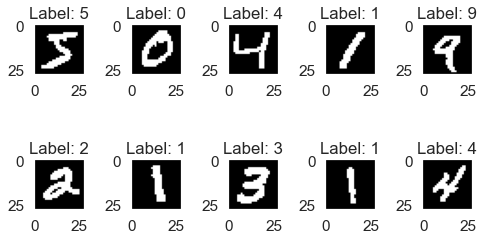

In [9]:
X_train = read_data("trainingimages")
X_test = read_data("testimages")
y_train = np.array(pd.read_csv("traininglabels", header=None, sep="\s+")).flatten()
y_test = np.array(pd.read_csv("testlabels", header=None, sep="\s+")).flatten()

# Plot some samples
fig, ax = plt.subplots(2,5, figsize=(7,4))
for i, ax in enumerate(ax.flatten()):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.grid(False)
# fig.suptitle("First 10 samples of train data", fontsize = 18)
fig.tight_layout()
plt.show()

In [10]:
# Training phase
# class probabilities (P(C))
prior = compute_prior(y_train)

# Liklihood probabilities (P(F_ij | class))
probabilities = estimate_pixel_probabilities(X_train, y_train)

# Test phase
estimates = group_predict_digit(X_test, prior, probabilities)

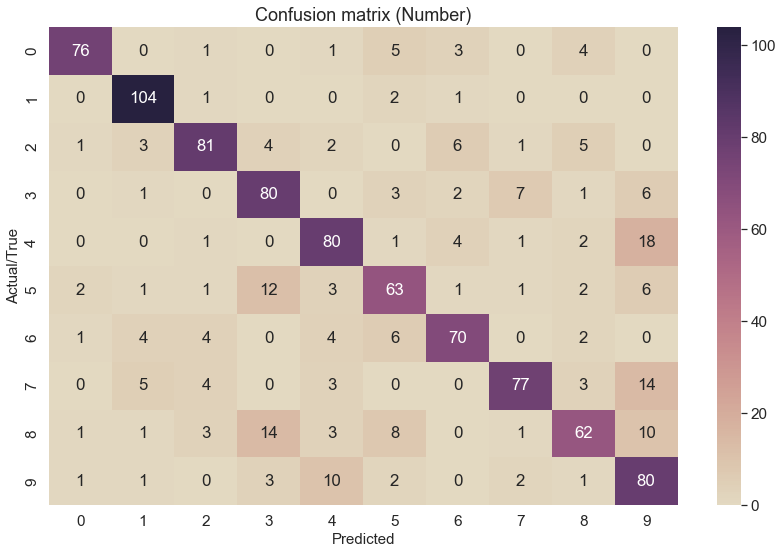

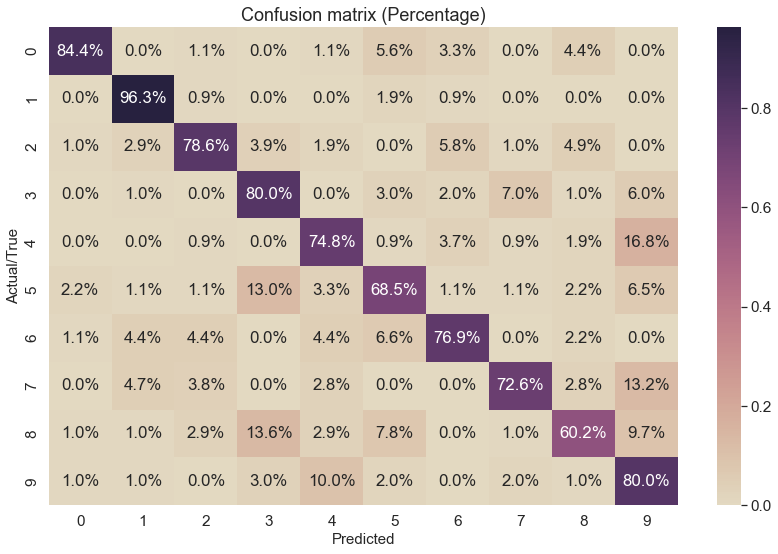

In [11]:
import seaborn as sn

num_conf_matrix, percent_conf_matrix = get_confusion_matrix(estimates, y_test, prior)
df_cm = pd.DataFrame(num_conf_matrix, range(10), range(10))
plt.figure(figsize = (12, 8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt='d', cmap=sn.color_palette("ch:s=-.2,r=.6", as_cmap=True))
plt.title('Confusion matrix (Number)', fontsize = 18) 
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual/True', fontsize = 15) 
plt.tight_layout()
plt.show()

df_cm = pd.DataFrame(percent_conf_matrix, range(10), range(10))
plt.figure(figsize = (12, 8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt=".1%", cmap=sn.color_palette("ch:s=-.2,r=.6", as_cmap=True))
plt.title('Confusion matrix (Percentage)', fontsize = 18)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual/True', fontsize = 15) 
plt.tight_layout()
plt.show()

In [12]:
report_results(num_conf_matrix, len(y_test))

------------------------- Results -------------------------
Class    Recall          Precision       F1 Scores      
0        84.44           92.68           88.37          
1        96.3            86.67           91.23          
2        78.64           84.38           81.41          
3        80.0            70.8            75.12          
4        74.77           75.47           75.12          
5        68.48           70.0            69.23          
6        76.92           80.46           78.65          
7        72.64           85.56           78.57          
8        60.19           75.61           67.03          
9        80.0            59.7            68.38          
Accuracy:  77.3 %
------------------------------------------------------------
